In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from utils.stats import weighted_quantile
from data_gen_utils.data_gen_my4 import get_simu_data
from utils.utils import MyDataSet, get_idx_sets
from demo_settings import simu_settings
from CQR import get_CQR_CIs, boosting_pred, boosting_logi, get_CF_CIs
from mlp.train_mlp import TrainMLP
from ddpm.train_ddpm_now import TrainDDPM
from weighted_conformal_inference import WeightedConformalInference
from local_weighted_conformal_inference import LocalWeightedConformalInference, get_opth
from naive_sample import NaiveSample

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
from copy import deepcopy
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [5]:
setting = "setting3"

'setting3'

In [6]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = False
params.simu_setting.n = 3000
params.simu_setting.d = 10
params.simu_setting.ntest = 1000
params.simu_setting.cal_ratio = 0.45 # for conformal inference
params.simu_setting.val_ratio = 0.05 # for tuning network
params.simu_setting.update(simu_settings[setting])
params.simu_setting.n = 3000
params.simu_setting.d = 10 
pprint(params.simu_setting)


params.nrep = 50 # num of reptition for simulation
params.K = 40 # num of sps drawn from q(Y(1)|X)
params.save_snapshot = 500
params.df_dtype = torch.float32
params.device="cpu"
params.n_jobs = 20
params.verbose = True
params.inf_bs = 40 # the inference batch, fct x K

params.ddpm_training = edict()
# Batch size during training
params.ddpm_training.batch_size = 256 
# Number of training epochs
params.ddpm_training.n_epoch = 100
params.ddpm_training.n_infeat = 128
# Learning rate for optimizers
params.ddpm_training.lr = 0.001
params.ddpm_training.lr_gamma = 0.5
params.ddpm_training.lr_step = 1000
params.ddpm_training.test_intv = 5
params.ddpm_training.n_downblk = 1
params.ddpm_training.weight_decay = 1e-2
params.ddpm_training.early_stop = False
params.ddpm_training.early_stop_dict = {"early_stop_len":50, "early_stop_eps": 5e-4}
#params.ddpm_training.betas = [0.001, 0.5]

params.wconformal = edict()
# remove too large and too small in ws/mean(ws)
params.wconformal.nwthigh = 20
params.wconformal.nwtlow = 0.05
params.wconformal.useinf = False


params.hypo_test = edict()
params.hypo_test.alpha = 0.05 # sig level

params.prefix = ""
params.save_dir = f"demo_ddpm_{setting}_test11"
if not (RES_ROOT/params.save_dir).exists():
    (RES_ROOT/params.save_dir).mkdir()

{'cal_ratio': 0.25,
 'd': 10,
 'err_type': 'norm',
 'is_homo': False,
 'n': 3000,
 'ntest': 1000,
 'rho': 0.0,
 'val_ratio': 0.05}


In [7]:
torch.set_default_dtype(params.df_dtype)

In [8]:
keys = ["lr", "n_infeat", "weight_decay", "n_downblk"]
def _get_name_postfix(keys, ddpm_training):
    lst = []
    for key in keys:
        if ddpm_training[key] >= 1:
            lst.append(f"{key}-{str(ddpm_training[key])}")
        else:
            lst.append(f"{key}--{str(ddpm_training[key]).split('.')[-1]}")
    return "_".join(lst)

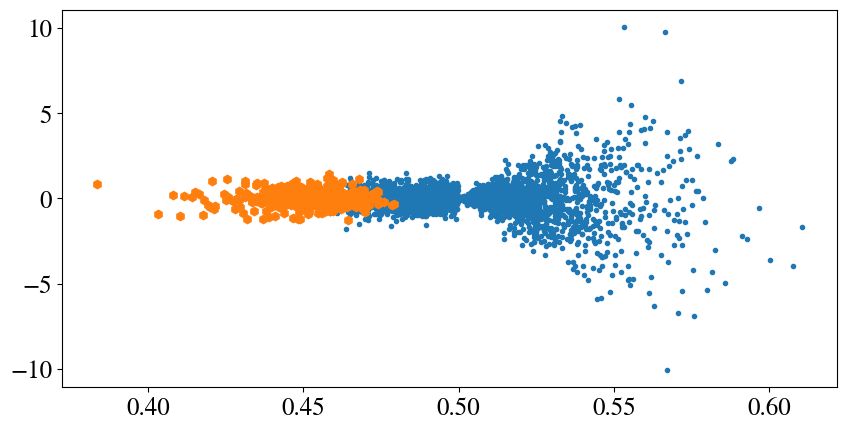

In [26]:
from data_gen_utils.data_gen_my4 import sdfun
data = get_simu_data(n=params.simu_setting.n, 
                           d=100, 
                           rho=params.simu_setting.rho, 
                           err_type=params.simu_setting.err_type);
errs = data.Y1 - data.tau
X = data.X
X0 = torch.tensor(X, dtype=params.df_dtype)
Xnorm = torch.norm(X0, p=2, dim=1).numpy()

cutoff = np.quantile(Xnorm, 0.1)
sel_ix = Xnorm < cutoff
sds = sdfun(X)
X_norm = np.linalg.norm(X, axis=1)
X_norm = X.mean(axis=1)
#plt.plot(X_norm, sds, ".")
plt.plot(X_norm, errs, ".")
plt.plot(X_norm[sel_ix], errs[sel_ix], "h")

In [23]:
errs.std()

1.036497888955996

In [24]:
errs[sel_ix].std()

0.5314297292203534

array([6.1542754, 5.9234676, 5.7751107, ..., 5.997085 , 6.063632 ,
       5.6975594], dtype=float32)

array([6.1542754, 5.9234676, 5.7751107, ..., 5.997085 , 6.063632 ,
       5.6975594], dtype=float32)

In [110]:
rep_ix = 1
params = params
lr = 1e-2
n_infeat = 256
weight_decay = 1e-2
n_blk = 3
manualSeed = rep_ix
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
params = edict(deepcopy(params))
params.ddpm_training.n_downblk = n_blk
params.ddpm_training.weight_decay = weight_decay
params.ddpm_training.lr = lr
params.ddpm_training.n_infeat = n_infeat
keys = ["lr", "n_infeat",  "weight_decay", "n_downblk"]
post_fix = _get_name_postfix(keys, params.ddpm_training)

torch.set_default_dtype(params.df_dtype)
torch.set_default_device(params.device)

        
        
data_train = get_simu_data(n=params.simu_setting.n, 
                           d=params.simu_setting.d, 
                           rho=params.simu_setting.rho, 
                           err_type=params.simu_setting.err_type);
data_test = get_simu_data(n=params.simu_setting.ntest, 
                           d=params.simu_setting.d, 
                           rho=params.simu_setting.rho,
                           err_type=params.simu_setting.err_type);


cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T)[0], 
                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
#cal_idxs, val_idxs, tr_idxs = get_idx_sets(all_idxs=np.where(data_train.T!=10)[0], 
#                                               ratios = [params.simu_setting.cal_ratio, params.simu_setting.val_ratio])
                
# get psfun
psY = data_train.T.astype(int)
psX = data_train.X
fit_res = boosting_logi(psY, psX);
def wsfun(X):
    eps=1e-10
    if isinstance(X, torch.Tensor):
        X = X.cpu().numpy()
    if X.ndim == 1:
        X = X.reshape(1, -1)
    est_ps = boosting_pred(X, fit_res)
    est_ws = 1/(est_ps+eps)
    return torch.tensor(est_ws, dtype=params.df_dtype).to(device=params.device)
    

cal_X = torch.tensor(data_train.X[cal_idxs], dtype=params.df_dtype)
cal_Y = torch.tensor(data_train.Y1[cal_idxs], dtype=params.df_dtype)
val_X = torch.tensor(data_train.X[val_idxs], dtype=params.df_dtype)
val_Y = torch.tensor(data_train.Y1[val_idxs], dtype=params.df_dtype)
test_X = torch.tensor(data_test.X, dtype=params.df_dtype)
test_Y = torch.tensor(data_test.Y1, dtype=params.df_dtype)

# get subset of all X
test_Xnorm = torch.norm(test_X, p=2, dim=1)
cutoff1 = torch.quantile(test_Xnorm, 0.1)
cutoff2 = torch.quantile(test_Xnorm, 0.9)
test_X1 = test_X[test_Xnorm<cutoff1].clone()
test_Y1 = test_Y[test_Xnorm<cutoff1].clone()
test_X1c = test_X[test_Xnorm>=cutoff1].clone()
test_Y1c = test_Y[test_Xnorm>=cutoff1].clone()
test_X2 = test_X[test_Xnorm<cutoff2].clone()
test_Y2 = test_Y[test_Xnorm<cutoff2].clone()
test_X2c = test_X[test_Xnorm>=cutoff2].clone()
test_Y2c = test_Y[test_Xnorm>=cutoff2].clone();
    
# train q(Y(1)|X)
data_train_ddpm = MyDataSet(Y=data_train.Y[tr_idxs], X=data_train.X[tr_idxs])
data_val = edict()
data_val.c = val_X
data_val.x = val_Y
input_params = edict(deepcopy(params.ddpm_training))
input_params.pop("n_epoch")
input_params.pop("early_stop")
input_params.pop("early_stop_dict")

{'early_stop_len': 50, 'early_stop_eps': 0.0005}

In [111]:
mlp_fit = TrainMLP(data_train_ddpm, 
                  save_dir=params.save_dir, 
                  verbose=params.verbose, prefix=f"rep{rep_ix}_{post_fix}", 
                  device=params.device,
                  **input_params)

2024-03-07 14:28:31,376 - mlp.train_mlp - INFO - The results are saved at /data/rajlab1/user_data/jin/MyResearch/DG-CITE_paper/notebooks/../mypkg/../results/demo_ddpm_setting3_test11.
2024-03-07 14:28:31,399 - mlp.train_mlp - INFO - The params is {'lr': 0.01, 'batch_size': 256, 'device': 'cpu', 'n_infeat': 256, 'n_downblk': 3, 'lr_gamma': 0.5, 'lr_step': 1000, 'test_intv': 5, 'weight_decay': 0.01}


The num of params is 1.52m. 
Adjusting learning rate of group 0 to 1.0000e-02.


In [112]:
mlp_fit.train(n_epoch=params.ddpm_training.n_epoch, 
              data_val=data_val, 
              save_snapshot=params.save_snapshot, 
              early_stop=params.ddpm_training.early_stop, 
              early_stop_dict=params.ddpm_training.early_stop_dict
              )

2024-03-07 14:28:31,651 - mlp.train_mlp - WARNING - We do not do early stop, so any args in early_stop_dict are ignored.
loss: 3.6297: 100%|█████████████████████████████████████████████| 100/100 [00:06<00:00, 16.14it/s, val loss=2.44]


In [113]:
net = mlp_fit.nn_model;

In [114]:
def _inner_fn(X, Y, net, LCP=None, h=0.3, verbose=1):
    # get the len of CI based on intvs, there intvs is a list, each ele is another list contains CIs ele=[CI1, CI2]
    _get_intvs_len = lambda intvs: np.array([sum([np.diff(iv) for iv in intv])[0] for intv in intvs]);
    # get weather vaule in vs is in CI in intvs or not 
    def _get_inset(vs, intvs):
        in_set = []
        for v, intv in zip(vs, intvs):
            in_set.append(np.sum([np.bitwise_and(v>iv[0], v<iv[1]) for iv in intv]))
        in_set = np.array(in_set)
        return in_set
    wcf = LocalWeightedConformalInference(cal_X, 
                         cal_Y,
                         gen_fn=net, 
                         #ws_fn=None, 
                         ws_fn=wsfun, 
                         verbose=verbose, 
                         gen_type="reg",
                         seed=manualSeed,
                         device=params.device,
                         wcf_params={
                            "nwhigh" : params.wconformal.nwthigh,
                            "nwlow" : params.wconformal.nwtlow,
                            "useinf": params.wconformal.useinf,
                         })
    wcf.add_data(X)
    intvs = wcf(local_method=LCP, 
                alpha=params.hypo_test.alpha, 
                lm_params={"h":h});
    prbs = np.mean(_get_inset(Y, intvs))
    mlen = np.mean(_get_intvs_len(intvs))
    return prbs, mlen

In [115]:
from collections import defaultdict as ddict
all_data = {
    "all_test": [test_X, test_Y], 
    "test1": [test_X1, test_Y1], 
    "test1c": [test_X1c, test_Y1c], 
    "test2": [test_X2, test_Y2], 
    "test2c": [test_X2c, test_Y2c], 
};
def _get_all_res(net, LCP=None, h=1):
    base_res = ddict(list)
    for ky in all_data:
        tX, tY = all_data[ky]
        prb, mlen = _inner_fn(tX, tY, net, LCP=LCP, h=h, verbose=0)
        base_res["data"].append(ky)
        base_res["prb"].append(prb)
        base_res["len"].append(mlen)
    res = pd.DataFrame(base_res)
    return res

In [116]:
ky = "test1"
tX, tY = all_data[ky]
net = net
LCP = "g-rlcp"
h = 0.5
prb, mlen = _inner_fn(tX, tY, net, LCP=LCP, h=h, verbose=0)

In [120]:
_get_all_res(net, LCP=None, h=1)

2024-03-07 14:29:00,955 - local_weighted_conformal_inference - WARNING - Check your input, h is not used.
2024-03-07 14:29:01,157 - local_weighted_conformal_inference - WARNING - Check your input, h is not used.
2024-03-07 14:29:01,193 - local_weighted_conformal_inference - WARNING - Check your input, h is not used.
2024-03-07 14:29:01,377 - local_weighted_conformal_inference - WARNING - Check your input, h is not used.
2024-03-07 14:29:01,555 - local_weighted_conformal_inference - WARNING - Check your input, h is not used.


,data,prb,len
0,all_test,0.939000,6.564665
1,test1,0.990000,6.591200
2,test1c,0.933333,6.561717
3,test2,0.954444,6.564198
4,test2c,0.800000,6.568868


In [130]:
_get_all_res(net, LCP="g-rlcp", h=0.3)

,data,prb,len
0,all_test,0.963000,9.862475
1,test1,0.950000,10.066285
2,test1c,0.965556,9.836417
3,test2,0.963333,9.713907
4,test2c,0.950000,10.189572


In [131]:
_get_all_res(net, LCP="g-rlcp", h=0.4)

,data,prb,len
0,all_test,0.959000,8.726193
1,test1,0.970000,8.709260
2,test1c,0.953333,8.607889
3,test2,0.961111,8.549623
4,test2c,0.910000,9.689114


In [44]:
_get_all_res(net, LCP="b-rlcp", h=0.3*np.sqrt(params.simu_setting.d))

,data,prb,len
0,all_test,0.986000,24.639812
1,test1,0.930000,24.639812
2,test1c,0.988889,24.639812
3,test2,0.993333,24.639812
4,test2c,0.970000,24.639812
